In [1]:
import argparse
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from joblib import Parallel, delayed
from collections import OrderedDict
import matplotlib.pyplot as plt
from utilities.meta_utils import tensors_to_device


from learner.BasicLearner import BasicLearner
from learner.PerturbatedMetaLearnerRegressor import PerturbatedMetaLearner, ResidualMetaLearner
from network.meta_network import MetaNetworkWithPertubation, NoisyMetaNetwork
from task.TaskGenerator import SinTaskGenerator
from utilities.folder_management import handle_folder_creation


ModuleNotFoundError: No module named 'learner.PerturbatedMetaLearnerRegressor'

In [ ]:
# Network parameters
INPUT_SIZE = 1
OUTPUT_SIZE = 1
HIDDEN_SIZE = (10, 10, 10)

TRAINING_EPOCHS = 10
TEST_PERCENTAGE = 0.2

NET_LR = 0.01

# Meta parameters
FIRST_ORDER = False
RES_STOCHASTIC_ITERATION = 30
RES_LR = 0.001

# Dataset parameters
MIN_X = -5
MAX_X = 5

BATCH_SIZE = 128
LATER_BATCH_SIZE = 10

NUM_BATCH_FIRST_TASK = 1000
NUM_BATCH_LATER_TASK = 5

MAX_BATCHES_FIRST_TASK = 2000
MAX_BATCHES_LATER_TASK = 30

SIMULATE_MAX_BATCHES = 1000
SIMULATE_BATCH_SIZE = 32
SIMULATE_N_BATCHES = 250
SIMULATE_TEST_SPLIT = 0.2

# Task parameters
AMPLITUDE_LIST = [1, 1.4, 1.8, 2.2, 2.8, 3.2, 3.6, 4.0, 4.4, 4.0, 3.6, 3.2, 3.6, 3.2, 3.2, 2.8]
PHASE_LIST = [0, 0.3, 0.6, 0.8, 1.0, 1.3, 1.6, 1.3, 1.6, 1.3, 1.0, 1.5, 1.8, 1.4, 1.5, 1.3]
n_tasks = len(AMPLITUDE_LIST)

In [5]:
task_generator: SinTaskGenerator = SinTaskGenerator(x_min=MIN_X, x_max=MAX_X)
device = "cpu"
init_mean_w = torch.zeros(HIDDEN_SIZE[-1], device=device)
init_std_w = torch.ones(HIDDEN_SIZE[-1], device=device)
init_mean_b = torch.zeros(OUTPUT_SIZE, device=device)
init_std_b = torch.ones(OUTPUT_SIZE, device=device)
net: torch.nn.Module = NoisyMetaNetwork(n_in=INPUT_SIZE, n_out=OUTPUT_SIZE, hidden_sizes=HIDDEN_SIZE,
                                        init_mean_w=init_mean_w, init_std_w=init_std_w,
                                        init_mean_b=init_mean_b, init_std_b=init_std_b)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=NET_LR)
learner: ResidualMetaLearner = ResidualMetaLearner(network=net,
                                                   n_in=INPUT_SIZE,
                                                   n_out=OUTPUT_SIZE,
                                                   optimizer=optimizer,
                                                   loss_function=loss,
                                                   x_space=task_generator.x_space,
                                                   device=device,
                                                   first_order=FIRST_ORDER,
                                                   learn_step_size=True)

In [6]:
learner.network.load_state_dict(torch.load("task_0_sin"))

<All keys matched successfully>

In [7]:
def plot(task_generator, amplitude_list, phase_list, model, perturbation=False, p_iter=5,
        plot_true=False, legend=False):
    x_points = task_generator.x_space
    
    if plot_true:
        i = 0
        for a, p in zip(amplitude_list, phase_list):
            y_points = a * torch.sin(x_points - p)
            plt.plot(x_points[0], y_points[0], label="Task {}".format(i))
            i += 1
    
    if perturbation:
        for i in range(0, p_iter):
            plt.plot(x_points[0], model(task_generator.x_space[0].unsqueeze(1), perturbation=perturbation).detach(), label="Net {}".format(i))
    else:
        plt.plot(x_points[0], model(task_generator.x_space[0].unsqueeze(1), perturbation=perturbation).detach(), label="Net")
    
    if legend:
        plt.legend()
    plt.show()

In [8]:
def plot_model_list(task_generator, amplitude_list, phase_list, model_list):
    x_points = task_generator.x_space
    
    i = 0
    for a, p in zip(amplitude_list, phase_list):
        y_points = a * torch.sin(x_points - p)
        plt.plot(x_points[0], y_points[0], label="Task {}".format(i))
        i += 1
    
    for i in range(len(model_list)):
        plt.plot(x_points[0], model_list[i](task_generator.x_space[0].unsqueeze(1)).detach(), label="Net {}".format(i))
    
    plt.legend()
    plt.show()

In [9]:
def task_adaptation(l, data_loader, max_batches):
    num_batches = 0
    optim = torch.optim.SGD(l.network.parameters(), lr=l.step_size)

    while num_batches < max_batches:
        for batch in data_loader:
            if num_batches >= max_batches:
                break
            batch = tensors_to_device(batch['train'], device=device)
            for i in range(l.num_adaptation_steps):
                inputs = batch[0]
                target = batch[1]
                optim.zero_grad()
                pred = l.network(inputs)
                loss = l.loss_function(pred, target)
                loss.backward()
                optim.step()
            num_batches += 1

In [10]:
good_model_task_0 = NoisyMetaNetwork(n_in=INPUT_SIZE, n_out=OUTPUT_SIZE, hidden_sizes=HIDDEN_SIZE,
                                        init_mean_w=init_mean_w, init_std_w=init_std_w,
                                        init_mean_b=init_mean_b, init_std_b=init_std_b)
good_model_task_0.load_state_dict(learner.network.state_dict())
good_model_task_0.set_learn_net(False)
good_model_task_0.set_learn_noise(False)

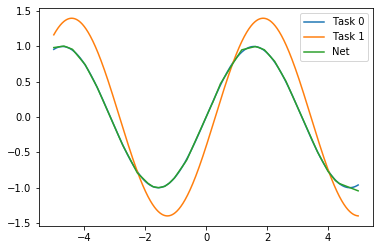

In [11]:
plot(task_generator, AMPLITUDE_LIST[0:2], PHASE_LIST[0:2], perturbation=False, p_iter=1, legend=True, plot_true=True,
    model=learner.network)

In [12]:
SIMULATE_MAX_BATCHES = [250, 750, 1500, 3000, 5000, 10000, 20000, 30000, 40000, 50000]
SIMULATE_BATCH_SIZE = 32
SIMULATE_N_BATCHES = [250, 700, 1000, 1500, 3000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
SIMULATE_TEST_SPLIT = 0.2
n_trials = len(SIMULATE_MAX_BATCHES)

learner_list = []
step_size_list = []

for i in range(n_trials):
    n_batches = SIMULATE_N_BATCHES[i] 
    max_batches = SIMULATE_MAX_BATCHES[i] if i == 0 else SIMULATE_MAX_BATCHES[i] - SIMULATE_MAX_BATCHES[i-1]
    
    learner.simulate_meta_training(num_batches=n_batches,
                                   batch_size=SIMULATE_BATCH_SIZE,
                                   test_split=SIMULATE_TEST_SPLIT,
                                   max_batches=max_batches,
                                   verbose=True)
    new_model = NoisyMetaNetwork(n_in=INPUT_SIZE, n_out=OUTPUT_SIZE, hidden_sizes=HIDDEN_SIZE,                                        init_mean_w=init_mean_w, init_std_w=init_std_w,
                                            init_mean_b=init_mean_b, init_std_b=init_std_b)
    new_model.load_state_dict(learner.network.state_dict())
    new_model.set_learn_net(True)
    new_model.set_learn_noise(True)
    learner_list.append(new_model)
    step_size_list.append(learner.step_size.item())

100%|██████████| 250/250 [00:10<00:00, 23.19it/s, loss=0.6578] 
501it [00:20, 24.69it/s, loss=0.2396]                         
751it [00:22, 33.88it/s, loss=0.0188]                         
100%|██████████| 1500/1500 [00:31<00:00, 48.28it/s, loss=0.0030]
2001it [00:41, 48.16it/s, loss=0.1778]                          
100%|██████████| 10000/10000 [04:03<00:00, 41.12it/s, loss=0.0133]


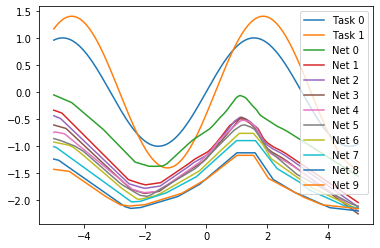

In [13]:
plot_model_list(task_generator, AMPLITUDE_LIST[0:2], PHASE_LIST[0:2], learner_list)

In [14]:
# Storing after meta results
after_meta_list = []
for net in learner_list:
    new_model = NoisyMetaNetwork(n_in=INPUT_SIZE, n_out=OUTPUT_SIZE, hidden_sizes=HIDDEN_SIZE,
                                init_mean_w=init_mean_w, init_std_w=init_std_w,
                                init_mean_b=init_mean_b, init_std_b=init_std_b)
    new_model.load_state_dict(net.state_dict())
    new_model.set_learn_net(False)
    new_model.set_learn_noise(False)
    after_meta_list.append(new_model)

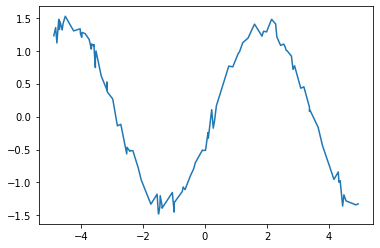

In [15]:
# Adaptation to task 1... let's see how it goes...
task = 1
num_batches = NUM_BATCH_FIRST_TASK if task == 0 else 1
bs = BATCH_SIZE if task == 0 else 128
max_batches = MAX_BATCHES_FIRST_TASK if task == 0 else MAX_BATCHES_LATER_TASK

data_loader_2 = task_generator.get_data_loader(amplitude=AMPLITUDE_LIST[task],
                                                     phase=PHASE_LIST[task],
                                                     num_batches=num_batches,
                                                     batch_size=bs,
                                                     test_perc=TEST_PERCENTAGE)
idx = data_loader_2[0]['train'][0].squeeze(1).sort().indices
plt.plot(data_loader_2[0]['train'][0][idx], data_loader_2[0]['train'][1][idx])

In [85]:
# Storing after meta results
learner_list = []
for net in after_meta_list:
    new_model = NoisyMetaNetwork(n_in=INPUT_SIZE, n_out=OUTPUT_SIZE, hidden_sizes=HIDDEN_SIZE,
                                init_mean_w=init_mean_w, init_std_w=init_std_w,
                                init_mean_b=init_mean_b, init_std_b=init_std_b)
    new_model.load_state_dict(net.state_dict())
    new_model.set_learn_net(False)
    new_model.set_learn_noise(False)
    learner_list.append(new_model)

for i, net in enumerate(learner_list):
    net.set_learn_net(True)
    net.set_learn_noise(True)
    learner.network = net
    learner.step_size = step_size_list[i]
    task_adaptation(l=learner, data_loader=data_loader_2, max_batches=30)
    net = learner.network

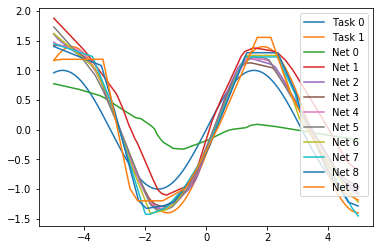

In [86]:
plot_model_list(task_generator, AMPLITUDE_LIST[0:2], PHASE_LIST[0:2], learner_list)

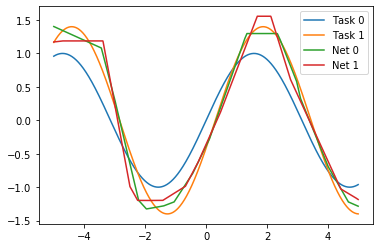

In [87]:
plot_model_list(task_generator, AMPLITUDE_LIST[0:2], PHASE_LIST[0:2], learner_list[-2:])

In [ ]:
# Finally, let's try to adapt starting from the good_model of task 0 with 30 batches...

In [69]:
good_model_task_0.set_learn_net(True)
good_model_task_0.set_learn_noise(True)
learner.network = good_model_task_0
learner.step_size = torch.tensor(step_size_list).mean().item()
task_adaptation(l=learner, data_loader=data_loader_2, max_batches=30)
good_model_task_0 = learner.network

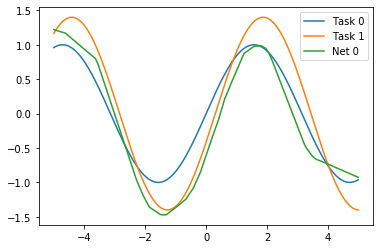

In [70]:
plot_model_list(task_generator, AMPLITUDE_LIST[0:2], PHASE_LIST[0:2], [good_model_task_0])

In [79]:
data_loader_2[0]['train'][0].shape

torch.Size([102, 1])

In [88]:
# Now, let's take the best model and study its performances while augmenting the number of available iterations...
learner_list = []
for net in after_meta_list:
    new_model = NoisyMetaNetwork(n_in=INPUT_SIZE, n_out=OUTPUT_SIZE, hidden_sizes=HIDDEN_SIZE,
                                init_mean_w=init_mean_w, init_std_w=init_std_w,
                                init_mean_b=init_mean_b, init_std_b=init_std_b)
    new_model.load_state_dict(net.state_dict())
    new_model.set_learn_net(False)
    new_model.set_learn_noise(False)
    learner_list.append(new_model)

max_batches_list = [10, 30, 50, 70, 100, 120, 150, 200]
net = learner_list[-1]
after_adapation_last_model_list = []
for i, m_b in enumerate(max_batches_list):
    net.set_learn_net(True)
    net.set_learn_noise(True)
    learner.network = net
    learner.step_size = step_size_list[-1]
    task_adaptation(l=learner, data_loader=data_loader_2, max_batches=m_b)
    net = learner.network
    
    new_model = NoisyMetaNetwork(n_in=INPUT_SIZE, n_out=OUTPUT_SIZE, hidden_sizes=HIDDEN_SIZE,
                                init_mean_w=init_mean_w, init_std_w=init_std_w,
                                init_mean_b=init_mean_b, init_std_b=init_std_b)
    new_model.load_state_dict(net.state_dict())
    new_model.set_learn_net(False)
    new_model.set_learn_noise(False)
    after_adapation_last_model_list.append(new_model)


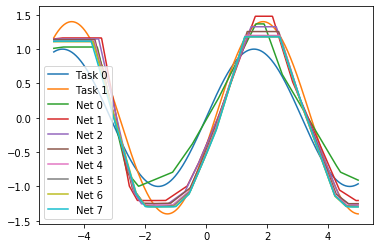

In [89]:
plot_model_list(task_generator, AMPLITUDE_LIST[0:2], PHASE_LIST[0:2], after_adapation_last_model_list)